# Quantum-Informed Recursive Optimization

This tutorial will give you an overview of problem specific implementations for solving optimization problems with the [Quantum Approximate Optimization Algorithm (QAOA)](/reference/Algorithms/qaoa/QAOA.html).

The Quantum Approximate Optimization Algorithm (QAOA), is used to solve combinatorical optimization problem instances of NP-hard problems. For further information see our [tutorial on QAOA](QAOAtutorial/index.html)! 

The paper [Quantum-Informed Recursive Optimization Algorithms (2023)](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.020327) by J. Finzgar et. al. establishes a blueprint for developing alogrithms that update the problem instance recursively, based on the correlations in results obtained by QAOA.
While QAOA cost functions are designed with specific problem instances in mind, this research has shown promising improvements to this to approach by further leveraging the problem structure.

We have implemented this approach for different problem instances, namely [MaxClique](../../reference/Algorithms/qiro/implementations/QIROMaxClique.rst), [MaxIndependentSet](../../reference/Algorithms/qiro/implementations/QIROMaxIndep.rst), [MaxSat](../../reference/Algorithms/qiro/implementations/QIROMaxSat.rst) and [MaxSetPacking](../../reference/Algorithms/qiro/implementations/QIROMaxSetPack.rst). The explanation below tackles the [Maximum Indepent Set (MIS)](https://en.wikipedia.org/wiki/Maximal_independent_set) problem, in analogy to the original paper by Finzgar et. al.

## Starting point of the algorithm

The algorithm evaluates the result of a [QAOA](../../reference/Algorithms/qaoa/QAOA.rst) optimization procedure to establish correlations in the solution space, then recursively updates the problem structure. We will further assume that you are already mostly familiar with QAOA.  

The MIS is defined via a graph with a set of vertices $V$ and a set of edges $E$ . To solve this optimization problem, one has to find the maximum number of vertices, where none of the vertices share a common edge, i.e. we want to find

$$ \max \left( |V'| , V' \subset V \right), \text{ where } \sum_{ i, j \in V' } \mathbb{1}_{(i,j) \in E} = 0 $$

The QAOA cost operator has the form 

$$H_C = - \sum_{i \in V} ( \textbf{1} - Z_i ) + 3  \sum_{i,j \in E} ( \textbf{1} - Z_i )( \textbf{1} - Z_j ),$$

and the mixer operator is

$$H_M = - \sum_{i \in V} Z_i .$$

Executing the optimization loop of our QAOA implementation of depth $p$ will result in the state 

$$|\psi\rangle = e^{i \beta^{*}_{p-1} H_M} e^{i \gamma^{*}_{p-1} H_C} \dotsb e^{i \beta^{*}_0 H_M} e^{i \gamma^{*}_0 H_C} ( |0\rangle + |1\rangle )^{\otimes n},$$

with $n$ being the number of vertices in the graph. The parameters $\{\gamma^{*}_{p-1}, \beta^{*}_{p-1}, \dotsc, \gamma^{*}_0 , \beta^{*}_0 \}$ represent the optimized QAOA angles.
This state $|\psi\rangle$ is the starting point of the **Quantum-Informed Recursive Optimization** considerations.

## Establishing correlations 

We quickly want to motivate the search for correlations with the arguments made in the original paper. For further detail we again refer to the original paper by [J. Finzgar et. al.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.020327) 

Firstly, QAOA is a local algorithm, which was shown to severely limit its performance. In turn, applying non-local updates classically has been proposed, i.e., in recursive QAOA (RQAOA) implementations. Values of variables are iteratively frozen as given by the correlations in the measurements of
the quantum state prepared in a QAOA optimization routine. In QIRO, this information is used to recursively decrease the size of the problem instance by introducing problem-specific classical optimization routines. With this, new connections between previously unconnected nodes non-local effects are introduced, counterbalancing the locality inherent to QAOA.


For any problem specific QIRO implementation the next step is to evaluate the expected correlations in the solution space, i.e., computing the values of the matrix $\text{M}$, where
$\text{M}_{ii} = \langle\psi| Z_i |\psi\rangle$ and $\text{M}_{ij} = \langle\psi| Z_i Z_j |\psi\rangle$.

We then need to find the **maximum absolute value** of $\text{M}$.

## Reducing the problem 

Based on the **maximum absolute entry** of the correlation matrix M and its sign, one of the following replacements is employed:

* If $\text{M}_{ii} \geq 0$ is the maximum absolute value, then the $i$-th vertex is set to be in the independent set (IS). In turn, all vertices that share an edge with this vertex can be removed from the graph, since including them in the solution would violate the problem constraints.

* If $\text{M}_{ii} < 0$ is the maximum absolute value, we remove $i$-th vertex from the graph.

* If $\text{M}_{ij} > 0, (i, j) ∈ E$ was selected, we remove both vertices from the graph with the argument, that, since both of them would be in the same state in the final solution, including both as part of the solution would violate the constraint, as they share an edge. In turn, they can be removed from the graph. 

* If $\text{M}_{ij} < 0, (i, j) ∈ E$ was selected, we remove all vertices that share an edge with both vertices $i$ and $j$. Since one of the vertices $i$ and $j$ will be part of the final solution (but not both), any vertex that is connected to both $i$ and $j$ is guaranteed to violate the problem constraints, and can be removed from the graph. In this case, it may be possible that no vertex is found to be a canditate for being removed. We will then simply choose the second biggest absolute value of **M** for the replacement routine.


These operations are performed on a copy of the ``networkx`` graph that was provided to the instance of the [QIROProblem](../../reference/Algorithms/qiro/QIRO.rst) class, see the code example below. 
Based on the reduced problem graph, the ``cost_operator``, ``mixer``, and ``init_function`` are updated.
Subsequently, we optimize the parameters for the simplified ``QAOAProblem`` instance, and reduce the problem again with the same subroutine as described above.

## The final solution

The after a specific number of recursions the final solution is returned as the result of a ``QAOAProblem`` optimization routine, 
where we consider the excluded and included vertices from the above steps in the ``cost_operator``, ``mixer`` and ``init_function`` of the ``QAOAProblem``.

The final result is therefore a dictionary of measurement results from the ``.run`` method of the [QAOAProblem](../../reference/Algorithms/qaoa/QAOAProblem.rst) class and poses an optimized solution to the initial full problem instance. 

Try it out yourself with the example code below!

# QIRO implementation

## The QIRO class

Upon instantiation, the [QIROProblem](../../reference/Algorithms/qiro/QIROProblem.rst) class requires five arguments: 

* The ``problem`` to be solved, which not necessarly a graph, since QIRO is also implemented for [MaxSat](../../reference/Algorithms/qiro/implementations/QIROMaxSat.rst).
* The ``replacement_routine``, which has the job of performing the aforementioned specific reductions to the ``problem`` object.
* The ``cost_operator``, ``mixer``, ``cl_cost_function`` and ``init_function`` in analogy to [QAOAProblem](../../reference/Algorithms/qaoa/QAOAProblem.rst) instantiation. 

Why the ``cost_operator``, ``mixer``, and ``init_function`` undergo some slight adjustements, will be made clear in the code example below, as well as the necessity 
for directly assigning a ``cost_operator``, a ``mixer``, and an ``init_function``.

To run the instance and solve the optimization problem we use the ``.run`` method, which takes the following arguments:
``qarg``, ``depth``, ``n_recursions``, ``mes_kwargs = {}``, and ``max_iter = 50``.

* The [QuantumVariable](../../reference/Core/QuantumVariable.rst) ``qarg``, which is the quantum argument the algorithm is evaluated on.
* The integer ``depth``, which is the depth of QAOA optimization circuit.
* The integer ``n_recursions``, representing the number of QIRO update steps.
* The dictionary ``mes_kwargs = {}``, an empty dictionary by default, to define further specifications of the measurements.
* The integer ``max_iter = 50``, set to 50 by default, which defines the maximum number of the classical optimization loop with the ``COBYLA`` optimizer as part of the QAOA optimization routine

# Maximum independent set example

We now investigate a code example for the maximum independent set problem. The in-depth explanation will focus on the unconnected cost operator implementation displayed. 
In constrast, our [general QAOA implementation for the MIS problem](../../reference/Algorithms/qaoa/implementations/maxIndepSet.rst) is based on a constrained mixer approach. This can also be used for the QIRO implementation, 
which we show at the end of this tutorial!

## Preliminaries

Before we get to the superficial code let us first do some explaining of the relevant aspects, starting with the ``replacment_routine``.

All in all, the function remains straight forward. We employ a ``find_max`` subroutine to find the entry and the sign of the maximum correlation value, to then adjust the graph.

In [1]:
def create_maxIndep_replacement_routine(res, graph, solutions=[], exclusions=[]):

    # for multi qubit correlations
    orig_edges = [list(item) for item in graph.edges()]

    # for single qubit correlations
    orig_nodes = list(graph.nodes())
    
    max_item = []
    max_item, sign = find_max(orig_nodes, orig_edges , res, solutions)

    # create a copy of the graph
    new_graph = copy.deepcopy(graph)

    # we remove nodes from the graph, as suggested by the replacement rules
    # if the item is an int, it is a single node, else it is an edge
    if isinstance(max_item, int):
        if sign > 0:
            # remove all adjacent nodes
            to_remove = graph.adj[max_item]
            new_graph.remove_nodes_from(to_remove)
            solutions.append(max_item)
            exclusions += to_remove

        elif sign < 0:
            # remove the node
            new_graph.remove_node(max_item)
            exclusions.append(max_item)

    else:
        if sign > 0:
            # remove both nodes
            new_graph.remove_nodes_from(max_item)
            exclusions += list(max_item)

        elif sign < 0:
            # remove all nodes connected to both nodes 
            intersect = list(set( list(graph.adj[max_item[0]].keys()) ) & set( list(graph.adj[max_item[0]].keys()) ))
            new_graph.remove_nodes_from(intersect)
            exclusions += intersect 

    return new_graph, solutions, sign, exclusions

As you might have noticed in the code above, we add the nodes that are included into (respective excluded from) the solution to a list ``solutions`` (``exclusions``). 
This allows us to directly use the same ideas for the  ``cost_operator``, ``mixer`` and ``init_function`` of the original unconstrained QAOA theory with minor adjustments.

Since we have to consider nodes that are already asigned to be in the solution set, or exluded from the algorithm, we do not want to apply ``cost_operator`` or ``mixer`` to said nodes. 
We therefore include some simple lines of code into the functions to take this into account, for example the ``if not``-statement in the ``qiro_rx_mixer``:

In [2]:
def qiro_rx_mixer(solutions = [], exclusions = []):
    union = solutions + exclusions
    def RX_mixer(qv, beta):
        for i in range(len(qv)):
            # DONT mix solutions or exclusions
            if not i in union:
                rx(2 * beta, qv[i])
    return RX_mixer

Similarly an ``if not``-statement is included in the cost operator, which is named ``create_max_indep_cost_operator_reduced`` due to it respecting the problem reduction:

In [3]:
def create_max_indep_cost_operator_reduced(problem_updated):

    problem = problem_updated[0]
    solutions = problem_updated[1]
    def cost_operator(qv, gamma):
        for pair in list(problem.edges()):
            #cx(qv[pair[0]], qv[pair[1]])
            rzz(3*gamma, qv[pair[0]], qv[pair[1]])
            rz(-gamma, qv[pair[0]])
            rz(-gamma, qv[pair[1]])
        for i in problem.nodes():
            # DONT apply gates on nodes in the solution set
            if not i in solutions:
                rz(gamma, qv[i])

    return cost_operator

With the preliminaries out of the way, let us jump right into the code example:

## Code execution

We start off by defining the graph of our problem, as well as the [QuantumVariable](/reference/Quantum%20Types/QuantumVariable.html) to run our instance on:

In [ ]:
from qrisp import QuantumVariable
from qrisp.qiro import QIROProblem, create_max_indep_replacement_routine, create_max_indep_cost_operator_reduced, qiro_rx_mixer, qiro_init_function
from qrisp.qaoa import create_max_indep_set_cl_cost_function
import matplotlib.pyplot as plt
import networkx as nx

# define a random graph via the number of nodes and the QuantumVariable arguments
num_nodes = 13
G = nx.erdos_renyi_graph(num_nodes, 0.4, seed = 107)
qarg = QuantumVariable(G.number_of_nodes())

With this, we can directly throw everything that is relevant at the [QIROProblem](../../qiro/QIRO.rst) class and create an instance.

In [5]:
# assign the correct new update functions for qiro 
qiro_instance = QIROProblem(G,
                            replacement_routine=create_max_indep_replacement_routine,
                            cost_operator=create_max_indep_cost_operator_reduced,
                            mixer=qiro_rx_mixer,
                            cl_cost_function=create_max_indep_set_cl_cost_function,
                            init_function=qiro_init_function
                            )

We think of arguments for the [.run_qiro](../../qiro/QIRO.rst#qrisp.qiro.QIROProblem.run_qiro) method, run the algorithm, et violà!

In [6]:
res_qiro = qiro_instance.run_qiro(qarg=qarg, depth=3, n_recursions=2)

All done! We have solved the MIS problem using Quantum-Informed Recursive Optimization!

## Results

But of course, we also want to investigate our results, so let's find out about the five most likely solutions the algorithm came up with:

In [7]:
cl_cost = create_max_indep_set_cl_cost_function(G)

print("5 most likely QIRO solutions")
max_five_qiro = sorted(res_qiro, key=res_qiro.get, reverse=True)[:5]
for res in max_five_qiro: 
    print([index for index, value in enumerate(res) if value == '1'])
    print(cl_cost({res : 1}))

5 most likely QIRO solutions
[6, 7, 10, 11]
-4
[7, 10, 11]
-3
[4, 6, 7, 10, 11]
-5
[2, 7, 10, 11]
-4
[6, 7, 10]
-3


We do not put the example output here, since the algorithm is not deterministic, and the output you receive may differ from what an example might show. Just go ahead and try it yourself!

We can further compare our results to the [NetworkX MIS algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.mis.maximal_independent_set.html) for solving the MIS problem:

In [8]:
print("Networkx solution")
print(nx.approximation.maximum_independent_set(G))

Networkx solution
{0, 4, 5, 9, 12}


As a final caveat, we can look at the graph we are left with after all reduction steps.

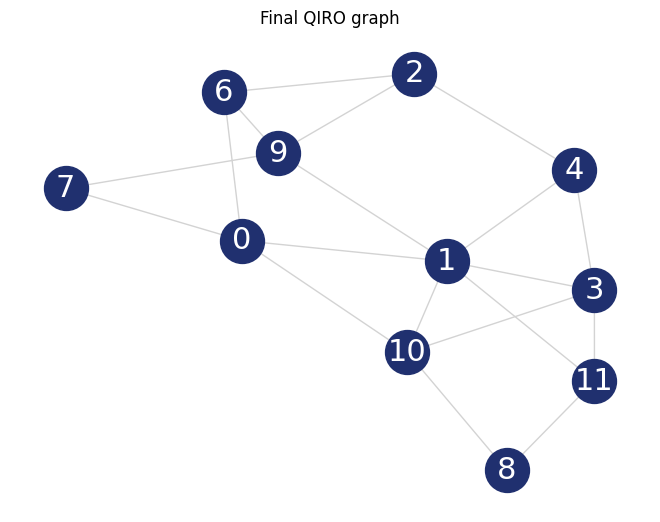

In [9]:
final_graph = qiro_instance.problem
plt.figure(1)
nx.draw(final_graph, with_labels=True, font_color='white', node_size=1000, font_size=22,
 node_color='#20306f', edge_color='#D3D3D3')
plt.title('Final QIRO graph')
plt.show()

## Constrained mixer implementation

Before we end this tutorial we want to show you what the constrained mixer implementation looks like for the MIS QIRO algorithm. In analogy to our [general QAOA implementation for the MIS problem](../../qaoa/max_indep_set_qaoa.rst) 
we use the [qiro_rz_mixer](../../qiro/QIRO.rst) as the mixer and the [create_max_indep_controlled_mixer_reduced](../../qiro/MaxIndependentSetQIRO.rst) as the cost operator. In principle, these functions do the exact same thing as the general implementations,
but they respect the solutions and exclusions chosen via the update routine.  We suggest to try this instance with larger graph sizes (more than 20 nodes).

In [ ]:
from qrisp.algorithms.qiro import qiro_rz_mixer, create_max_indep_controlled_mixer_reduced, qiro_max_indep_set_init_function

# assign the correct update functions for constrained qiro 
qiro_instance = QIROProblem(G, 
                            create_max_indep_replacement_routine,
                            qiro_rz_mixer,
                            create_max_indep_controlled_mixer_reduced,
                            create_max_indep_set_cl_cost_function,
                            qiro_max_indep_set_init_function,
                            )

# We run the qiro instance and get the results!
res_qiro = qiro_instance.run_qiro(qarg=qarg, depth=3, n_recursions=1)


In [11]:
cl_cost = create_max_indep_set_cl_cost_function(G)

print("5 most likely QIRO solutions")
max_five_qiro = sorted(res_qiro, key=res_qiro.get, reverse=True)[:5]
for res in max_five_qiro:
    print([index for index, value in enumerate(res) if value == '1'])
    print(cl_cost({res : 1}))

5 most likely QIRO solutions
[0, 3, 5, 8, 9, 12]
-6
[3, 5, 6, 7, 8, 12]
-6
[2, 3, 7, 8]
-4
[0, 4, 5, 8, 9, 12]
-6
[1, 6, 7, 8]
-4


Congratulations, you have reached the end of the tutorial and are now capable of solving the MIS problem in Qrisp!
Should your appetite not be satisfied, we advise you to check out our other QIRO implementations:

* [MaxClique](../../reference/Algorithms/qiro/implementations/QIROMaxClique.rst) 
* [MaxSat](../../reference/Algorithms/qiro/implementations/QIROMaxSat.rst)
* [MaxSetPacking](../../reference/Algorithms/qiro/implementations/QIROMaxSetPack.rst)

and of course all the other material in the tutorial section!